In [1]:
import numpy as np
import xml.etree.ElementTree as ET
from pricing import ACT_365, DiscountingCurve, EquityForwardCurve, Curve
import lets_be_rational.LetsBeRational as lbr
from numpy import log, exp

### Matrice di volatilità dal mercato 

In [2]:
tree = ET.parse('TV_example.xml')
root = tree.getroot()

In [3]:
N_stocks = len(root[3][0][1][1][1][0])
names = np.array([])
for i in range(N_stocks):
    names=np.append(names,root[3][0][1][1][1][0][i].text)
delete_equity = [0,11,12,13,14,15]
names = np.delete(names,delete_equity)
reference_date = float(root[3][1][0][0][2][0].text)

In [4]:
index_equity = [3]
spot_prices = np.zeros(len(index_equity))
j = 0
for i in index_equity:
    if i>=6:
        spot_prices[j] = float(root[3][i+3][0][1][0][0].text)
    else:
        spot_prices[j] = float(root[3][3+i][0][0][1][0].text)
    j = j+1
spot_prices

array([405.06122627])

In [5]:
discounts = np.zeros(len(root[3][1][0][0][0][0][0]))
discounts_dates = np.zeros(len(root[3][1][0][0][0][0][0]))
for i in range(len(root[3][1][0][0][0][0][0])):
    discounts_dates[i] = float(root[3][1][0][0][0][0][0][i].text)
    discounts[i] = float(root[3][1][0][0][0][1][0][i].text)
D = DiscountingCurve(reference=reference_date, discounts=discounts, dates=discounts_dates, act="365")

zero interest rate time grid [0.00000000e+00 2.73972603e-03 5.47945205e-03 8.21917808e-03
 2.46575342e-02 4.38356164e-02 6.30136986e-02 9.31506849e-02
 1.72602740e-01 2.57534247e-01 3.42465753e-01 4.24657534e-01
 5.15068493e-01 5.91780822e-01 6.76712329e-01 7.31506849e-01
 7.53424658e-01 9.83561644e-01 1.00547945e+00 1.23287671e+00
 1.47945205e+00 1.72602740e+00 1.98082192e+00 2.01095890e+00
 2.23013699e+00 3.00821918e+00 4.00821918e+00 5.00821918e+00
 6.00821918e+00 7.00821918e+00 8.01369863e+00 9.01095890e+00
 1.00109589e+01 1.10109589e+01 1.20136986e+01 1.30191781e+01
 1.40164384e+01 1.50136986e+01 1.60164384e+01 1.70164384e+01
 1.80164384e+01 1.90219178e+01 2.00191781e+01 2.10191781e+01
 2.20191781e+01 2.30191781e+01 2.40273973e+01 2.50246575e+01
 2.60219178e+01 2.70219178e+01 2.80246575e+01 2.90246575e+01
 3.00301370e+01 3.10273973e+01 3.20273973e+01 3.30273973e+01
 3.40273973e+01 3.50273973e+01 3.60328767e+01 3.70301370e+01
 3.80301370e+01 3.90301370e+01 4.00328767e+01 5.00383562

In [6]:
F = []
max_dates = np.array([])
index = 0
for i in index_equity:
    if i>=6:
        repo_dates = np.array([reference_date+1, max(max_dates)])
        repo_rates = np.zeros(2)
        F.append(EquityForwardCurve(reference=reference_date, discounting_curve=D, repo_dates=repo_dates,repo_rates=repo_rates, spot=spot_prices[index],act="360"))
    else:
        repo_dates = np.zeros(len(root[3][3+i][0][0][0][0][0]))
        repo_rates = np.zeros(len(root[3][3+i][0][0][0][1][0]))
        for j in range (len(root[3][3+i][0][0][0][0][0])):
            repo_dates[j] = float(root[3][3+i][0][0][0][0][0][j].text)
            repo_rates[j] = float(root[3][3+i][0][0][0][1][0][j].text)
        max_dates = np.append(max_dates,max(repo_dates))
        F.append(EquityForwardCurve(reference=reference_date, discounting_curve=D, repo_dates=repo_dates,repo_rates=repo_rates, spot=spot_prices[index],act="360"))
    index = index+1
F = F[0]

Forward repo time grid [0.         0.49444444 1.50555556 2.51666667 3.52777778 4.55833333
 5.56944444]
Forward repo rate:  [-0.002 -0.002 -0.002 -0.002 -0.002 -0.002 -0.002]


In [7]:
for i in index_equity:
    vola_dates = np.zeros(len(root[3][i+3][1][2][0][0]))
    vola_strikes = np.zeros(len(root[3][i+3][1][2][2][0]))
    for j in range(len(root[3][i+3][1][2][0][0])):
        vola_dates[j] = float(root[3][i+3][1][2][0][0][j].text)
    for j in range(len(root[3][i+3][1][2][2][0])):
        vola_strikes[j] = float(root[3][i+3][1][2][2][0][j].text)
    market_vola = np.zeros(len(root[3][i+3][1][2][0][0])*len(root[3][i+3][1][2][2][0]))
    for k in range (len(market_vola)):
        market_vola[k] = float(root[3][i+3][1][2][1][0][k].text)
    market_vola = np.reshape(market_vola,(len(vola_dates),len(vola_strikes))).T
vola_maturities = ACT_365(vola_dates, reference_date)

In [8]:
market_vola.shape, vola_maturities.shape, vola_strikes.shape

((29, 13), (13,), (29,))

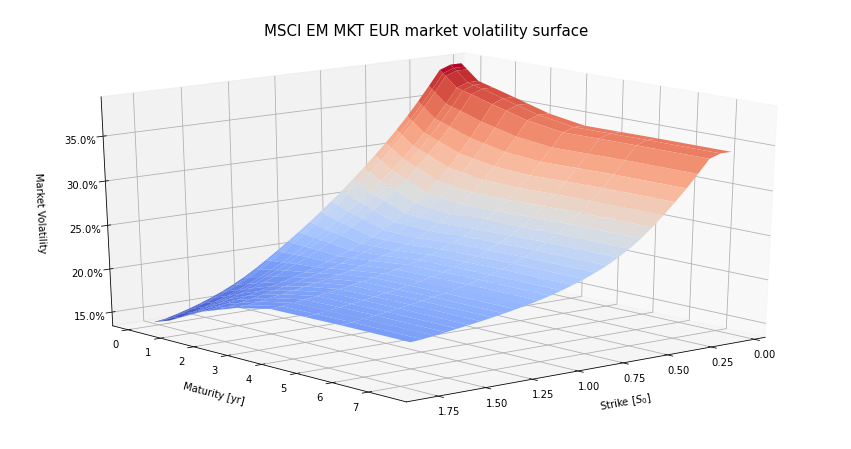

In [9]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import ticker 

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
X,Y = np.meshgrid(vola_strikes/spot_prices[0], vola_maturities)
Z = market_vola.T

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=1,antialiased=True)

ax.set_xlabel('Strike [$S_0$]',labelpad=15)
ax.set_ylabel('Maturity [yr]',labelpad=15)
ax.set_zlabel('Market Volatility',labelpad=13)
ax.zaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.title(names[int(index_equity[0]-1)]+' market volatility surface',fontsize=15)
ax.view_init(20, 50)
#plt.savefig('gra1hs/ATM_PriceDiff_BS_Market.png')
plt.show()

### Normalizing Data

In [10]:
%%time
N = len(vola_maturities)
M= len(vola_strikes)
for i in range (M):
    if i ==0:
        k = vola_strikes[i]/F(vola_maturities)
    else:
        k = np.vstack([k, vola_strikes[i]/F(vola_maturities)])
k.shape

CPU times: user 149 ms, sys: 0 ns, total: 149 ms
Wall time: 149 ms


(29, 13)

### Functions for Local Volatility Model

In [11]:
from scipy.interpolate import interp1d,RegularGridInterpolator
class LocalVolatilityCurve(Curve):
    
    def __init__(self, market_volatility=None, strikes=None, maturities=None):
        self.volatilities = market_volatility
        self.K = strikes
        self.T = maturities
        self.vola_interpolated = RegularGridInterpolator((self.K,self.T),self.volatilities, bounds_error=False, fill_value=None)
    
    def curve(self,date_price):
        return self.vola_interpolated(np.array(date_price))
    

### Test of the methods

In [12]:
def A_i_matrix(alpha_i, beta_i, gamma_i):
    b = np.diag(beta_i)
    a = np.diag(alpha_i[1:],k=-1)
    c = np.diag(gamma_i[:-1],k=1)
    A = a +b +c
    A[0] = 0
    A[-1] = 0
    return A

In [13]:
def alpha_i_vector(eta_i_plus, dh):
    """Calculates the alpha_i coefficients of the tri-diagonal matrix"""
    return (eta_i_plus**2) * 0.5 * (-(0.5/dh)-1/(dh**2))

def beta_i_vector(eta_i_plus, dh):
    """Calculates the beta_i coefficients of the tri-diagonal matrix"""
    return (eta_i_plus**2) * (1/(dh**2))


def gamma_i_vector(eta_i_plus, dh):
    """Calculates the gamma_i coefficients of the tri-diagonal matrix"""
    return (eta_i_plus**2) * 0.5 * ((0.5/dh)-1/(dh**2))



In [14]:
def forward_euler_method_test(c_in,L_t,h_min,h_max,L_h, eta_curve):
    c_i = c_in
    Delta_t = T/L_t
    Delta_h = (h_max-h_min)/(L_h+1)
    h_grid = np.linspace(h_min,h_max,L_h+1)
    for i in range(L_t):
        t2 = (i)*Delta_t
        t = np.ones(L_h+1)*t2
        node_evaluation = np.stack((exp(h_grid)*F(t),t),axis=1)
        curve = eta_curve(node_evaluation)
        alpha_i = alpha_i_vector(curve, Delta_h)
        beta_i = beta_i_vector(curve, Delta_h)
        gamma_i = gamma_i_vector(curve, Delta_h)
        A_i = A_i_matrix(alpha_i,beta_i,gamma_i)
        c_i = c_i - Delta_t* A_i@c_i
    return c_i

In [15]:
def crank_nicolson_method_test(c_in,L_t,h_min,h_max, L_h,eta_curve):
    Delta_t = T/L_t
    Delta_h = (h_max-h_min)/(L_h+1)
    h_grid = np.linspace(h_min,h_max,L_h+1)
    for i in range(L_t):
        t2 = np.ones(L_h+1)*(i+1)*Delta_t
        t1 = np.ones(L_h+1)*(i)*Delta_t
        node_evaluation_1 = np.stack((exp(h_grid)*F(t1),t1),axis=1)
        node_evaluation_2 = np.stack((exp(h_grid)*F(t2),t2),axis=1)
        alpha_i = alpha_i_vector(eta_curve(node_evaluation_1), Delta_h)
        beta_i = beta_i_vector(eta_curve(node_evaluation_1), Delta_h)
        gamma_i = gamma_i_vector(eta_curve(node_evaluation_1), Delta_h)
        A_i_1 = A_i_matrix(alpha_i,beta_i,gamma_i)
        alpha_i = alpha_i_vector(eta_curve(node_evaluation_2), Delta_h)
        beta_i = beta_i_vector(eta_curve(node_evaluation_2), Delta_h)
        gamma_i = gamma_i_vector(eta_curve(node_evaluation_2), Delta_h)
        A_i_2 = A_i_matrix(alpha_i,beta_i,gamma_i)
        c_in = np.linalg.inv((np.identity(L_h+1) + 0.5*Delta_t*A_i_2))@(np.identity(L_h+1) - 0.5*Delta_t*A_i_1)@c_i
    return c_in

In [16]:
def backward_euler_method_test(c_in, T, L_t, h_min, h_max, L_h, eta_curve):
    Delta_t = T/L_t
    Delta_h = (h_max-h_min)/(L_h+1)
    h_grid = np.linspace(h_min,h_max,L_h+1)
    c_i = c_in
    for i in range(L_t):
        t2 = (i+1)*Delta_t
        t = np.ones(L_h+1)*t2
        node_evaluation = np.stack((exp(h_grid)*F(t),t),axis=1)
        curve = eta_curve(node_evaluation)
        alpha_i = alpha_i_vector(curve, Delta_h)
        beta_i = beta_i_vector(curve, Delta_h)
        gamma_i = gamma_i_vector(curve, Delta_h)
        A_i = A_i_matrix(alpha_i,beta_i,gamma_i)
        c_i = np.linalg.inv((np.identity(L_h+1) + Delta_t*A_i))@c_i
    return c_i

In [17]:
h_max = log(5)
h_min = -h_max
print(r"$h_{min}$ ",h_min)
print(r"$h_{max}$ ",h_max)

$h_{min}$  -1.6094379124341003
$h_{max}$  1.6094379124341003


In [18]:
sigma_LV = LocalVolatilityCurve(market_vola,vola_strikes,vola_maturities)

In [19]:
T = 1
L_t = 500
L_h = 100
Delta_t = T/L_t
Delta_h = (h_max-h_min)/(L_h+1)
h = np.linspace(h_min,h_max,L_h+1)

h = np.linspace(h_min,h_max,L_h+1)
c_i = np.maximum(1-exp(h),np.zeros(L_h+1))   #call option at time 0
c_i[0] = 1-exp(h_min)
c_i[-1] = 0

In [20]:
%%time
forward =forward_euler_method_test(c_i,L_t,h_min,h_max, L_h, sigma_LV)

CPU times: user 12.7 s, sys: 0 ns, total: 12.7 s
Wall time: 12.7 s


In [21]:
%%time
backward = backward_euler_method_test(c_i,T, L_t, h_min, h_max, L_h, sigma_LV)

CPU times: user 29.5 s, sys: 1.11 s, total: 30.6 s
Wall time: 15.4 s


In [22]:
%%time
crank = crank_nicolson_method_test(c_i,L_t,h_min,h_max, L_h,sigma_LV)

CPU times: user 1min 2s, sys: 2.22 s, total: 1min 4s
Wall time: 32.2 s


Text(0, 0.5, 'Call price normalized')

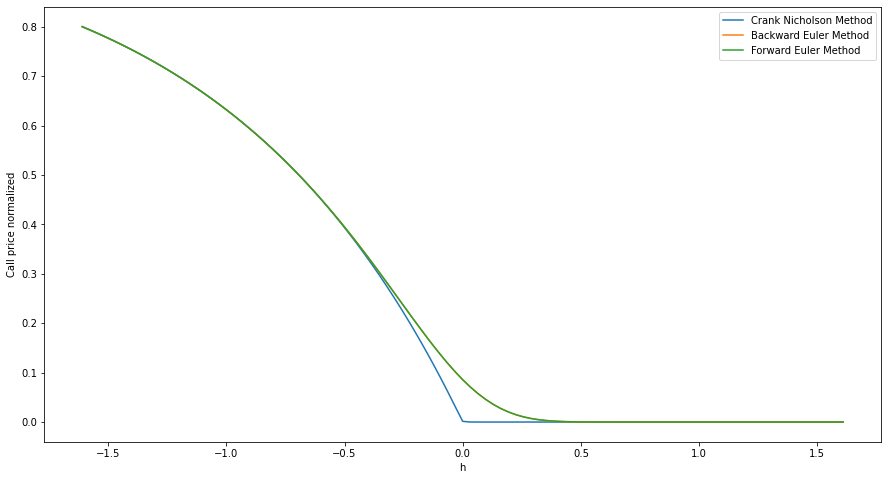

In [23]:
fig = plt.figure(figsize=(15,8))
plt.plot(h,crank, label='Crank Nicholson Method')
plt.plot(h,backward,label='Backward Euler Method')
plt.plot(h,forward,label='Forward Euler Method')
plt.legend()
plt.xlabel("h")
plt.ylabel("Call price normalized")

### Call option Pricer

In [19]:
def crank_nicolson_method(c_in,L_t,L_h,h_grid, Delta_h, Delta_t, eta_curve):
    for i in range(L_t):
        t2 = np.ones(L_h+1)*(i+1)*Delta_t
        t1 = np.ones(L_h+1)*(i)*Delta_t
        node_evaluation_1 = np.stack((exp(h_grid)*F(t1),t1),axis=1)
        node_evaluation_2 = np.stack((exp(h_grid)*F(t2),t2),axis=1)
        alpha_i = alpha_i_vector(eta_curve(node_evaluation_1), Delta_h)
        beta_i = beta_i_vector(eta_curve(node_evaluation_1), Delta_h)
        gamma_i = gamma_i_vector(eta_curve(node_evaluation_1), Delta_h)
        A_i_1 = A_i_matrix(alpha_i,beta_i,gamma_i)
        alpha_i = alpha_i_vector(eta_curve(node_evaluation_2), Delta_h)
        beta_i = beta_i_vector(eta_curve(node_evaluation_2), Delta_h)
        gamma_i = gamma_i_vector(eta_curve(node_evaluation_2), Delta_h)
        A_i_2 = A_i_matrix(alpha_i,beta_i,gamma_i)
        c_in = np.linalg.inv((np.identity(L_h+1) + 0.5*Delta_t*A_i_2))@(np.identity(L_h+1) - 0.5*Delta_t*A_i_1)@c_in
    return c_in

In [20]:
def backward_euler_method(c_in,L_t,L_h,h_grid, Delta_h, Delta_t, eta_curve):
    for i in range(L_t):
        t2 = (i+1)*Delta_t
        t = np.ones(L_h+1)*t2
        node_evaluation = np.stack((exp(h_grid)*F(t),t),axis=1)
        curve = eta_curve(node_evaluation)
        alpha_i = alpha_i_vector(curve, Delta_h)
        beta_i = beta_i_vector(curve, Delta_h)
        gamma_i = gamma_i_vector(curve, Delta_h)
        A_i = A_i_matrix(alpha_i,beta_i,gamma_i)
        c_in = np.linalg.inv((np.identity(L_h+1) + Delta_t*A_i))@c_in
    return c_in

In [36]:
def call_options_pricer(maturities, L_t, h_min, h_max, L_h, eta_curve, method = "Crank"):
    if method == 'Crank':
        algorithm = crank_nicolson_method
    else:
        algorithm = backward_euler_method
    Delta_h = (h_max-h_min)/(L_h+1)
    h_grid = np.linspace(h_min,h_max,L_h+1)
    c_i = np.maximum(1-exp(h_grid),np.zeros(L_h+1))   #call option at time 0
    c_i[0] = 1-exp(h_min)
    c_i[-1] = 0
    matrix_call = np.array([])
    for i in range(len(maturities)):
        print(i)
        if i == 0:
            Delta_t = maturities[i]/L_t
            matrix_call = algorithm(c_i,L_t,L_h,h_grid, Delta_h, Delta_t, eta_curve)
        if i>0:
            Delta_t = (maturities[i]-maturities[i-1])/L_t
        if i ==1:
            matrix_call = np.stack((matrix_call,algorithm(matrix_call,L_t,L_h, h_grid, Delta_h, Delta_t, eta_curve)),axis=1)
        if i>1:
            matrix_call = np.insert(matrix_call,-1,algorithm(matrix_call.T[i-1],L_t,L_h, h_grid, Delta_h, Delta_t, eta_curve),axis=1)

    return matrix_call

In [41]:
%%time
sigma_LV = LocalVolatilityCurve(market_vola,vola_strikes,vola_maturities)
h_max = log(10)
h_min = -h_max
L_h = 100
L_t = 50
maturities = vola_maturities
h_grid = np.linspace(h_min,h_max,L_h+1)
calls = call_options_pricer(maturities, L_t, h_min, h_max, L_h, sigma_LV, method="Crank")

0
1
2
3
4
5
6
7
8
9
10
11
12
CPU times: user 1min, sys: 1.76 s, total: 1min 2s
Wall time: 31.1 s


In [42]:
calls.shape

(101, 13)

In [ ]:
def from_price_to_vola(matrix_call, maturities, h):
    vola_matrix = np.zeros(matrix_call.shape)
    k = exp(h)
    for i in range(len(maturities)):
        for i in range(len(h)):
            vola_matrix[i,j] = lbr.implied_volatility_from_a_transformed_rational_guess(matrix_call[i],)

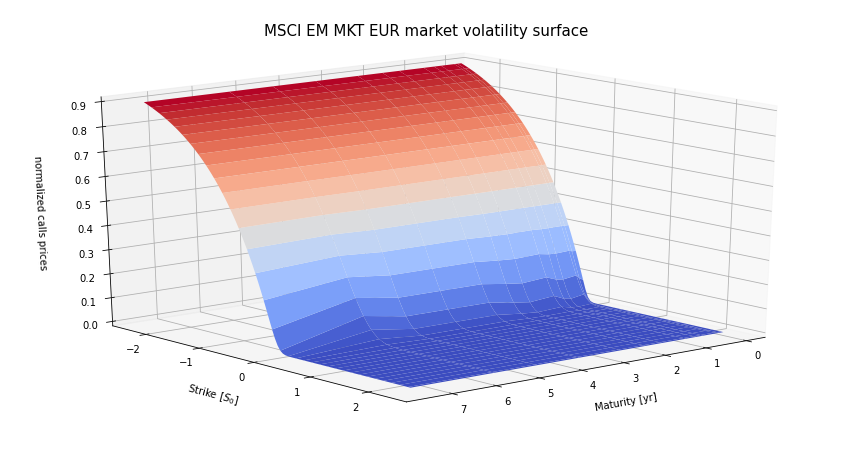

In [40]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
X,Y = np.meshgrid(maturities,h_grid )
Z = calls

ax.plot_surface(X, Y,Z , cmap=cm.coolwarm, linewidth=1,antialiased=True)

ax.set_ylabel('Strike [$S_0$]',labelpad=15)
ax.set_xlabel('Maturity [yr]',labelpad=15)
ax.set_zlabel('normalized calls prices',labelpad=13)
plt.title(names[int(index_equity[0]-1)]+' market volatility surface',fontsize=15)
ax.view_init(20, 50)
#plt.savefig('gra1hs/ATM_PriceDiff_BS_Market.png')
plt.show()

In [83]:
def function(time,price,market_data,market_strikes,market_vola):
    matrix_interpolated = interp1d(market_strikes,market_vola,axis=0,fill_value="extrapolate")(price)
    return interp1d(market_data,matrix_interpolated,kind='previous')(time)